# Example 2: Estimating the Gaia errors

The following exercise illustrates a typical problem in which the decomposition of particles into stars must be considered. One of the initial purposes of creating **Asgaia** was the resolution of this type of problems.

Imagine we have a set of particles, in which each of them has:
 * a sky position (lon, lat)
 * a distance from the Sun in kpc (dkpc)
 * a metal fraction (metZ)
 * an age in Gyrs (we use the decimal logarithm of the age: logAge)
 * a mass expressed in solar masses (mass)
 
For any reason, we want to know the uncertainty in parallax of each particle as it was observed by Gaia. Since the parallax error of Gaia depends mainly on the apparent fluxes in the V and Ic bands [see this webpage](https://www.cosmos.esa.int/web/gaia/science-performance), this task in non-trivial because particles have no magnitudes. We can consider, however, the mean parallax error of the stars that are contained in the particle (*sigma_pi*), and that's what **Asgaia** calculates.

The rest of the astrometric errors can be calculated from *sigma_pi*.

## 2.1 Long Way
### 2.1.1 Initialisation and particle catalogue loading

In [1]:
import numpy as np
import AsgaiaTools
import matplotlib.pyplot as plt

# Name of the file of the particles
filename = 'Particle_list.dat';

# Read the file
A = np.genfromtxt(filename, comments='#',names=True);

#Extract the data
lon = 1.*A['lon_rad'];
lat = 1.*A['lat_rad'];
dkpc = 1.*A['dist_kpc'];
metZ = 1.*A['met_Z'];
logAge = 1.*A['logAge_yrs'];
mass = 1.*A['mass_Msun'];
del(A);


### 2.1.2 Extinction estimation

Since we know the position of the particles, we can estimate the reddening for the stars of that particles using an extinction map. Although **Asgaia** makes use of the E(B-V) maps of Schlegel et al. 1999, it is not imcompatible with other maps.

To get the colour excess E(B-V) from the Schlegel maps, we proceed as follows:

In [2]:
E_BV = AsgaiaTools.ColourExcessMap(lon, lat);

The previous function returns the colour excess E(B-V) for source located very far. This value has to be corrected to account for the 3D structure of the Milky Way (Bland-Hawthorn et al. 2010):

In [3]:
Correction3D = AsgaiaTools.ColourExcess3DMap(lon, lat, dkpc);

We suggest to make use of the correction proposed by Sharma et al. 14:

In [4]:
A_V = 3.24*AsgaiaTools.SharmaCorrection(E_BV, Correction3D);
del(E_BV, Correction3D) # From now on, they are unuseful

Where we have multiplied by 3.24 to convert the colour excess to extinction in the V-band:

A_V = 3.24*E(B-V);

A_V is a numpy array with the estimation of the extinction (in the V band) for each particle.

The previous lines of code can be summarized with a single execution of the **Asgaia.GetAV()** function:

In [5]:
A_V = AsgaiaTools.GetAV(lon, lat, dkpc);

In case you prefer to use your extinction maps, substitute this sub-section by your A_V implementation.

### 2.1.3 Geometric correction

The parallax errors do not depend only on the luminosity but also on the attitude of the Gaia satellite through the [Geometric Correction](https://www.cosmos.esa.int/web/gaia/science-performance#astrometric performance):

In [6]:
geocorrection = AsgaiaTools.GeometricCorrection(lon, lat, interp_flag=True);

When interp_flag = False, uses the mean value of the Geometric Correction.

### 2.1.4 Mean parallax error estimation

*A_V* and *geocorrection* complete the set of inputs required for **AsgaiaTools.SigmaPiGaia()** to compute the mean parallax error.

The number of outputs of **AsgaiaTools.SigmaPiGaia()** depends on whether the "Mass" variable has been provided. If so, the output will be:

 * *sigma_pi*: an array with the mean parallax error for each particle.
 * *nobstars*: estimation of the number of stars observed by Gaia. Useful for statistics weighting.
 
otherwise, *nobstars* can not be calculated and only *sigma_pi* is returned.

In [7]:
[sigma_pi, nobstars]=AsgaiaTools.SigmaPiGaia(metZ, logAge, dkpc, A_V, geocorrection, Mass = mass);

We have run the most simple version of **AsgaiaTools.SigmaPiGaia** without setting the optional inputs. For more information, see the other examples and/or type AsgaiaTools.SigmaPiGaia? in your python IDE.

Now for each particle we know its mean parallax error.

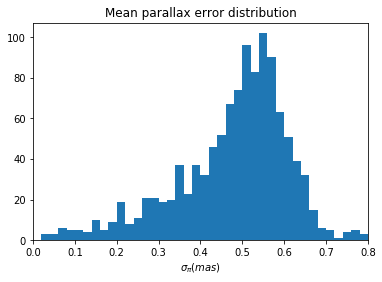

In [8]:
plt.figure();
plt.hist(sigma_pi,40, range=[0,0.8]);
plt.xlabel(r'$\sigma_\pi (mas)$');
plt.xlim([0,0.8]);
plt.title('Mean parallax error distribution')
plt.show()

## 2.2 Short Way

All of these previous steps can be summarized using **AsgaiaTools.GetSigmaPiGaia()**:

In [9]:
[sigma_pi2, nobstars2, A_V2]=AsgaiaTools.GetSigmaPiGaia(lon, lat, dkpc, metZ, logAge, mass);

which also returns the extinction A_V because it has to be calculated anyway.

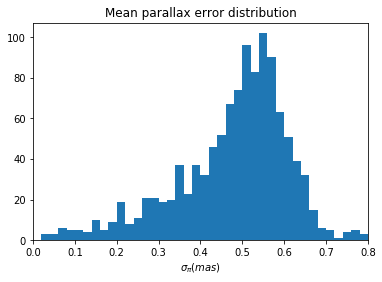

In [10]:
plt.figure();
plt.hist(sigma_pi2,40, range=[0,0.8]);
plt.xlabel(r'$\sigma_\pi (mas)$');
plt.xlim([0,0.8]);
plt.title('Mean parallax error distribution')
plt.show()

## 2.3 Comparison of the results

In [11]:
print(' The maximum difference in sigma_pi is : %.2f'%max(abs(sigma_pi2-sigma_pi)) );
print(' The maximum difference in nobstars is : %.2f'%max(abs(nobstars2-nobstars)) );
print(' The maximum difference in A_V is : %.2f'%max(abs(A_V-A_V2)) );

 The maximum difference in sigma_pi is : 0.00
 The maximum difference in nobstars is : 0.00
 The maximum difference in A_V is : 0.00


## 2.4 Astrometric errors

Once *sigma_pi* is known, we can estimate the errors in position and proper motions through the conversion factors given in this [table](https://www.cosmos.esa.int/web/gaia/table-2-with-ascii), which are implemented in the function **AsgaiaTools.ConversionSigmas()**.

In [12]:
[s_alphas, s_delta, s_muas, s_mud] = AsgaiaTools.ConversionSigmas(lon, lat, sigma_pi, flag=-1);

where s_alphas and s_muas refer to the positional and velocity (proper motion) error associated with the projected right ascension (i.e., they include the cos(dec) term). The last "s" in their name means "star"="asterisk".

If we had omitted *lon* and *lat*, the mean values of the conversion factors had been used.

The optional parameter *flag*, (de)activates the interpolation of the values of the mentioned table.

## 2.5 Spectroscopic errors

In this section we will estimate the errors in line of sight velocity using the function **AsgaiaTools.SigmaVrGaia()**, because the extinction A_V has already been calculated:

In [13]:
[sigma_Vr, nobstars] = AsgaiaTools.SigmaVrGaia(metZ, logAge, dkpc, A_V, mass);

We may have used **AsgaiaTools.GetSigmaVrGaia()**, as in the section 2.2, and the results would be the same:

In [14]:
[sigma_Vr2, nobstars, A_V3]=AsgaiaTools.GetSigmaVrGaia(lon, lat, dkpc, metZ, logAge, mass);

In [15]:
print 'Maximum difference in sigma_Vr : %.3f'%np.max(np.abs(sigma_Vr-sigma_Vr2))

Maximum difference in sigma_Vr : 0.000


Please, note that the number of observed stars *nobstars* may differ from that of the previous sections since an additional criteria is imposed in the selection function: G_RVS<16 ([see the discussion here](https://www.cosmos.esa.int/web/gaia/science-performance#spectroscopic performance)).

The use of **AsgaiaTools.SigmaVrGaia()** and **AsgaiaTools.GetSigmaVrGaia()** is analogue to that of **AsgaiaTools.SigmaPiGaia()** and **AsgaiaTools.GetSigmaPiGaia()** respectively.

## 2.6 Photometric errors

Regarding the photometry of Gaia, **Asgaia** implements two functions:
 * **AsgaiaTools.PhotometryGaia()**: returns \[mean_G, mean_GBP, mean_GRP, error_G, error_GBP, error_GRP, nobstars\]
 * **AsgaiaTools.GetPhotometryGaia()**: returns \[mean_G, mean_GBP, mean_GRP, error_G, error_GBP, error_GRP, nobstars, A_V\]
 
when the mass of the particles is not provided, *nobstars* is omitted.

Since we have calculated the extinction, we prefer to use **AsgaiaTools.PhotometryGaia()**:

In [138]:
[mean_G, mean_GBP, mean_GRP, error_G, error_GBP, error_GRP, nobstars] = AsgaiaTools.PhotometryGaia(metZ, logAge, dkpc, A_V, Mass = mass);

In [139]:
# Exclude particles whose stars are not observed:
is_selected = (nobstars>0.);

mean_G = mean_G[is_selected];
mean_GBP = mean_GBP[is_selected];
mean_GRP = mean_GRP[is_selected];
error_G = error_G[is_selected];
error_GBP = error_GBP[is_selected];
error_GRP = error_GRP[is_selected];

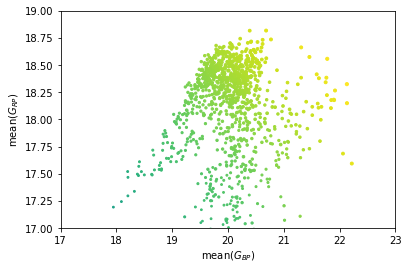

In [147]:
plt.figure('Photometry')
plt.scatter(mean_GBP, mean_GRP, c = mean_G, s = 10*error_G/np.max(error_G));
plt.xlabel(r'mean($G_{BP}$)')
plt.ylabel(r'mean($G_{RP}$)')
plt.axis([17.,23,17.,19.]); # Show only the Gaia's window
plt.show();

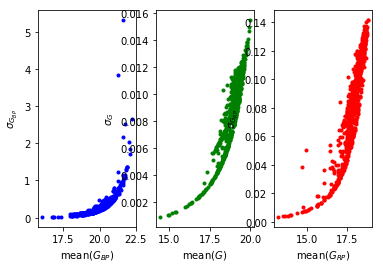

In [141]:
plt.figure('G Photometry')
plt.subplot(131)
plt.plot(mean_GBP,100.*error_GBP/mean_GBP,'b.');
plt.xlabel(r'mean($G_{BP}$)')
plt.ylabel(r'$\sigma_{G_{BP}}$')

plt.subplot(132)
plt.plot(mean_G,100.*error_G/mean_G,'g.');
plt.xlabel(r'mean($G$)')
plt.ylabel(r'$\sigma_{G}$')

plt.subplot(133)
plt.plot(mean_GRP,100.*error_GRP/mean_GRP,'r.');
plt.xlabel(r'mean($G_{RP}$)')
plt.ylabel(r'$\sigma_{G_{RP}}$')

plt.show();

In [142]:
output2 =AsgaiaTools.GetPhotometryGaia(lon, lat, dkpc, metZ, logAge, Mass=mass);
output = AsgaiaTools.PhotometryGaia(metZ, logAge, dkpc, A_V, Mass = mass);

In [143]:
# When a particle provides no stars, some elements are +/- inf.
# We will exclude them in the verification of outout2==output
is_selected = output[6]!=0; # output[6] is the number of observed stars (when the masses are provided)
output = [output[n][is_selected] for n in range(len(output))]

# Now for output2
is_selected = output2[6]!=0;
output2 = [output2[n][is_selected] for n in range(len(output))]


In [144]:
for n in range(0,len(output)):
    print 'Maximum difference between the elements %i is: '%n,np.max(np.abs(output[n]-output2[n]))

Maximum difference between the elements 0 is:  0.0
Maximum difference between the elements 1 is:  0.0
Maximum difference between the elements 2 is:  0.0
Maximum difference between the elements 3 is:  0.0
Maximum difference between the elements 4 is:  0.0
Maximum difference between the elements 5 is:  0.0
Maximum difference between the elements 6 is:  0.0


In [ ]:
# End of Example2